### Setup

In [1]:
from scipy import ndimage
from matplotlib import pyplot as plt

import torch.nn.functional as F
from torch.utils.data import DataLoader

from gelgenie.segmentation.networks.UNets.unet_model import smp_UNet

import skimage
from skimage.filters import sobel
from scipy import ndimage as ndi
from skimage.color import label2rgb

In [2]:
import logging
from pathlib import Path
import imageio
import cv2
import os

import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

from segmentation.helper_functions.general_functions import extract_image_names_from_folder


class BasicDataset(Dataset):
    def __init__(self, images_dir: str, n_channels: int, scale: float = 1.0,
                 augmentations=None, padding: bool = False, image_names=None):

        assert (n_channels == 1 or n_channels == 3), 'Dataset number of channels must be either 1 or 3'
        assert 0 < scale <= 1, 'Image scaling must be between 0 and 1'

        self.images_dir = Path(images_dir)
        self.n_channels = n_channels
        self.scale = scale
        self.standard_image_transform = transforms.Compose([transforms.ToTensor()])
        if image_names is not None:
            self.image_names = image_names
        else:
            self.image_names = extract_image_names_from_folder(images_dir)

        self.augmentations = augmentations
        self.padding = padding

        if padding:
            max_dimension = 0
            # loops through provided images and extracts the largest image dimension, for use if padding is selected
            for root, dirs, files in os.walk(self.images_dir):
                for name in files:
                    if name == '.DS_Store':
                        continue
                    image_file = os.path.join(root, name)
                    image = imageio.imread(image_file)  # TODO: investigate the warning here...
                    max_dimension = max(max_dimension, image.shape[0], image.shape[1])
            max_dimension = 32 * (max_dimension // 32 + 1)  # to be divisible by 32 TODO: why?

            self.max_dimension = max_dimension

        if not self.image_names:
            raise RuntimeError(f'No images found in {images_dir}, make sure you put your images there')
        logging.info(f'Creating dataset with {len(self.image_names)} examples')

    def __len__(self):
        return len(self.image_names)

    def set_augmentations(self, augmentations):
        self.augmentations = augmentations

    @staticmethod
    def load_image(self, filename, n_channels):
        image = imageio.imread(filename)

        # Converts to desired number of channels
        if n_channels == 1:  # Target input: 1 channel
            if image.shape[-1] == 3:  # Actual input: 3 channels
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            elif image.shape[-1] == 4:  # Actual input: 4 channels
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
            # No change required for already grayscale images
        elif n_channels == 3:  # Target input: 3 channels
            if image.shape[-1] == 4:  # Actual input: 4 channels
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            elif image.shape[-1] != 3:  # Actual input: 1 channels
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Normalizing image
        if image.dtype == 'uint8':
            max_val = 255
        elif image.dtype == 'uint16':
            max_val = 65535
        else:
            raise RuntimeError('Image type not recognized.')

        image = image.astype(np.float32) / max_val

        return image

    def __getitem__(self, idx):
        # print('Dataloader is %s, image IDX is: %s, image_name is %s' % ('validation' if not self.augmentations else 'Training', idx, self.image_names[idx]))
        # return np.zeros((5,5))
        img_file = self.image_names[idx]

        img_array = self.load_image(self, filename=img_file, n_channels=self.n_channels)

        if self.padding:
            top = (self.max_dimension - img_array.shape[0]) // 2
            bottom = self.max_dimension - img_array.shape[0] - top
            left = (self.max_dimension - img_array.shape[1]) // 2
            right = self.max_dimension - img_array.shape[1] - left

            img_array = np.pad(img_array, pad_width=((top, bottom), (left, right)), mode='constant')

        img_tensor = self.standard_image_transform(img_array)

        return img_tensor

In [3]:

nets = []

checkpoint_file_paths = ["/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_models/smp-UNet_No_Augmentations/checkpoints/checkpoint_epoch390.pth",
                         "/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_models/smp-UNet_with_Augmentations/checkpoints/checkpoint_epoch300.pth"]
n_channels = 1

def load_model(checkpoint):
    net = smp_UNet(
                encoder_name="resnet18",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
                in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
                classes=2,  # model output channels (number of classes in your dataset)
            )
    net.eval()
    saved_dict = torch.load(f=checkpoint, map_location=torch.device("cpu"))
    net.load_state_dict(saved_dict['network'])
    print(f'Model loaded from {checkpoint}')
    return net

for chkpt in checkpoint_file_paths:
    nets.append(load_model(chkpt))


Model loaded from /Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_models/smp-UNet_No_Augmentations/checkpoints/checkpoint_epoch390.pth
Model loaded from /Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_models/smp-UNet_with_Augmentations/checkpoints/checkpoint_epoch300.pth


### Full segmentation results

/var/folders/4x/_gjrrkj918v37xmw7d8n_p2h0000gn/T/ipykernel_74236/2324908946.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_file)  # TODO: investigate the warning here...
/var/folders/4x/_gjrrkj918v37xmw7d8n_p2h0000gn/T/ipykernel_74236/2324908946.py:60: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


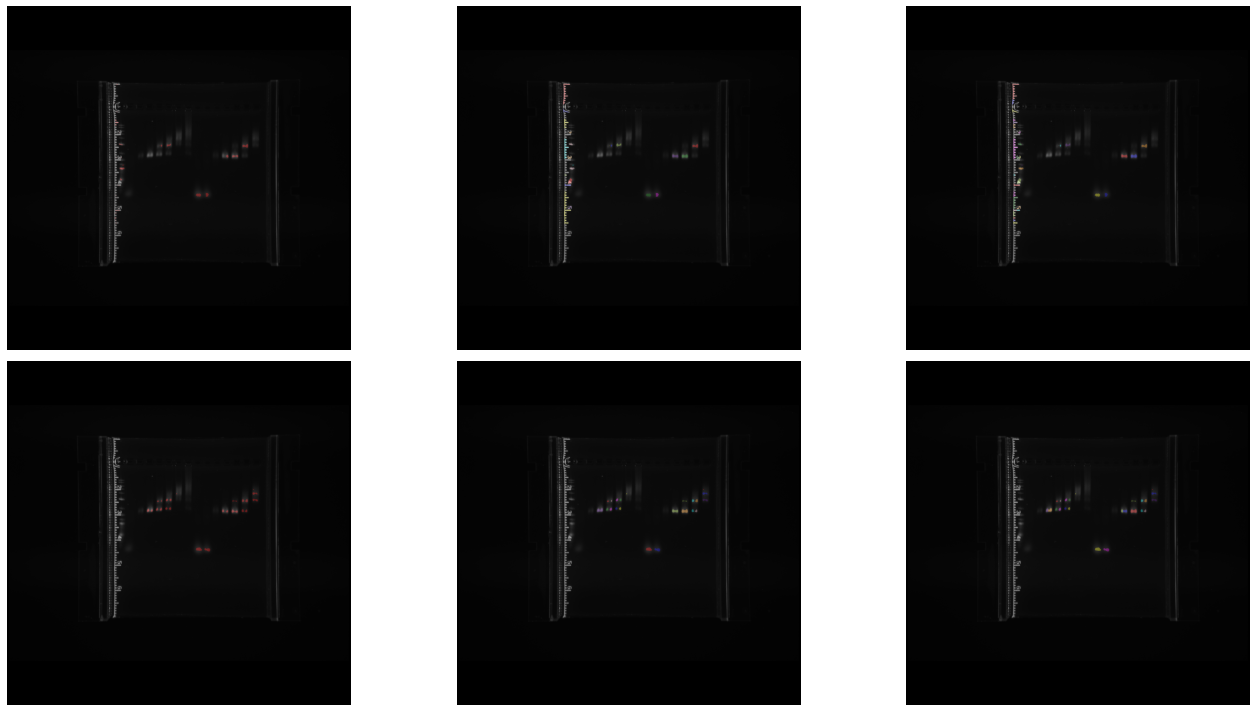

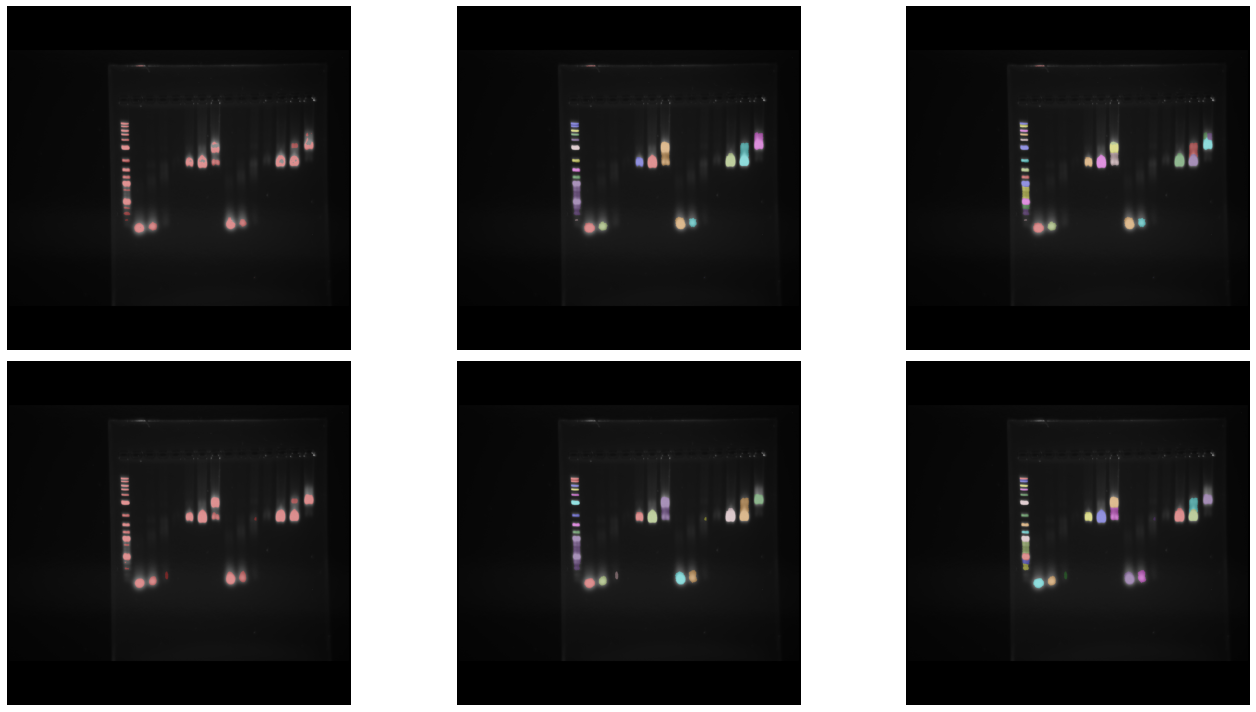

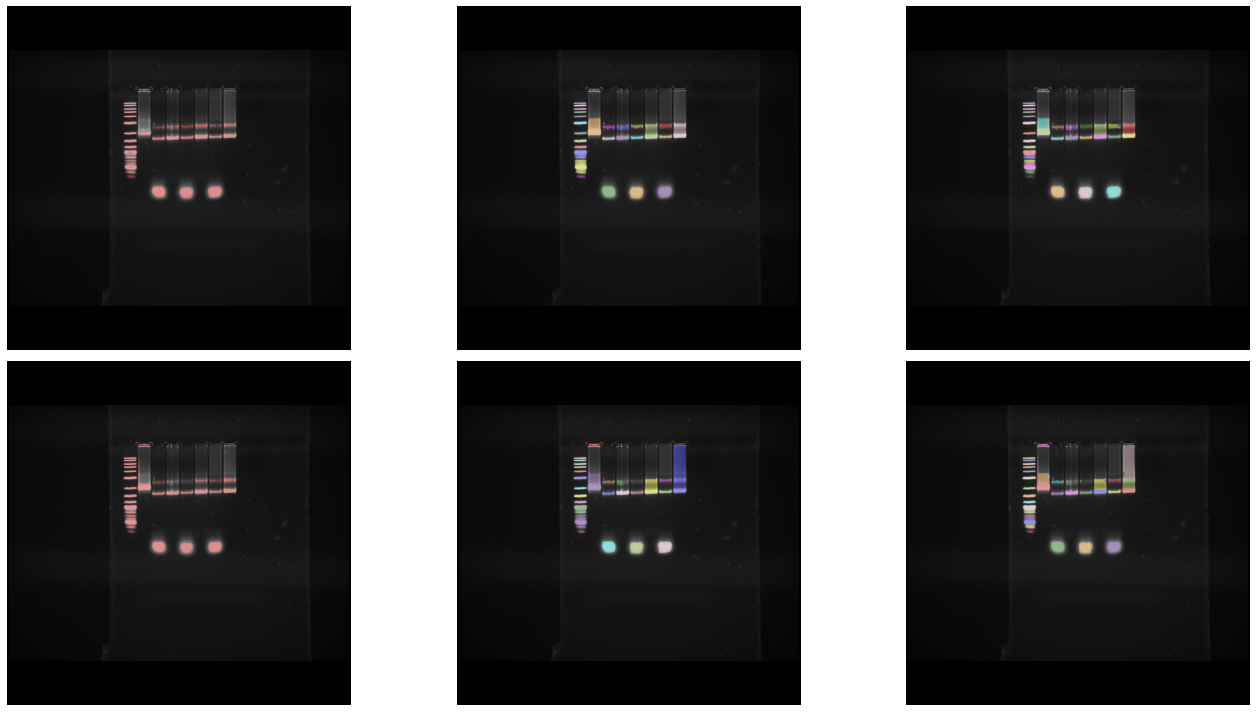

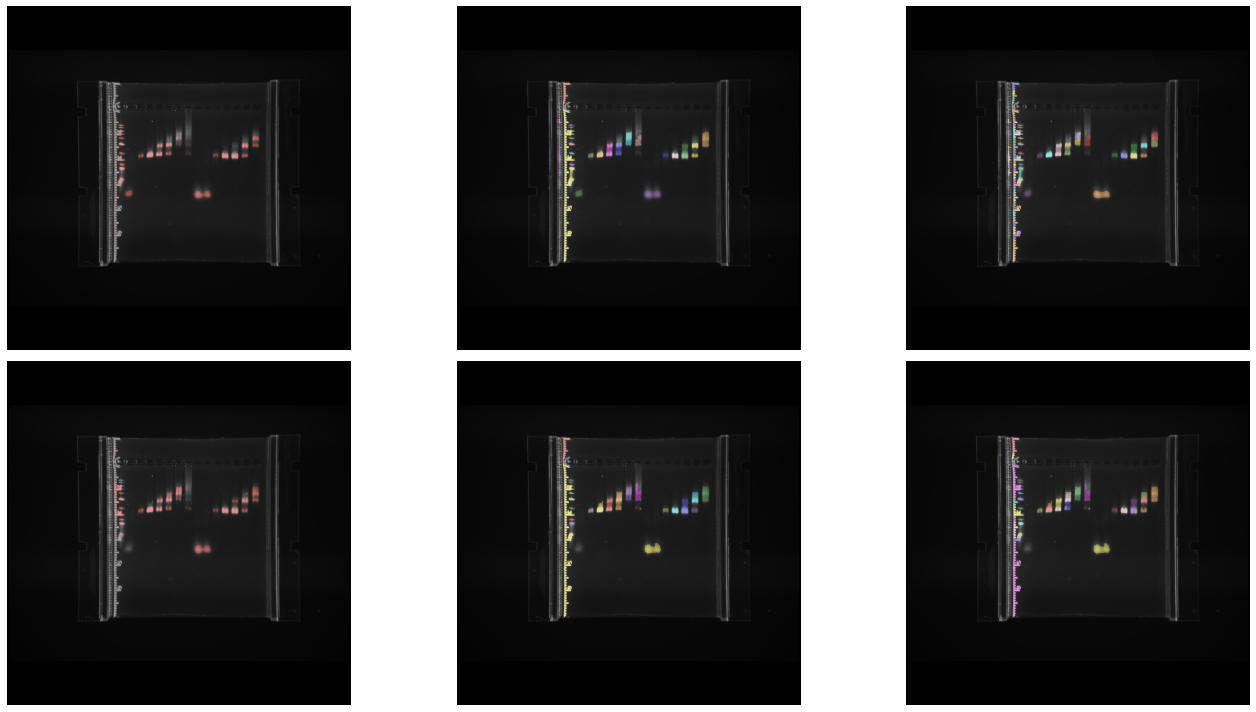

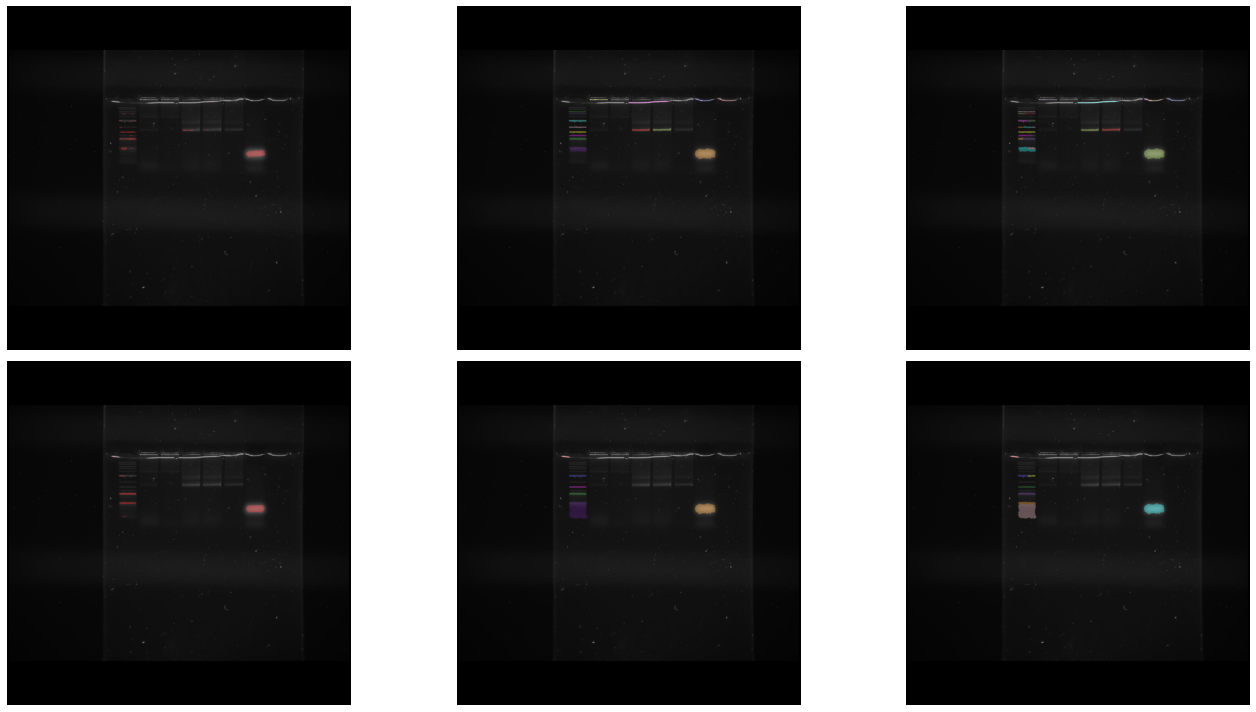

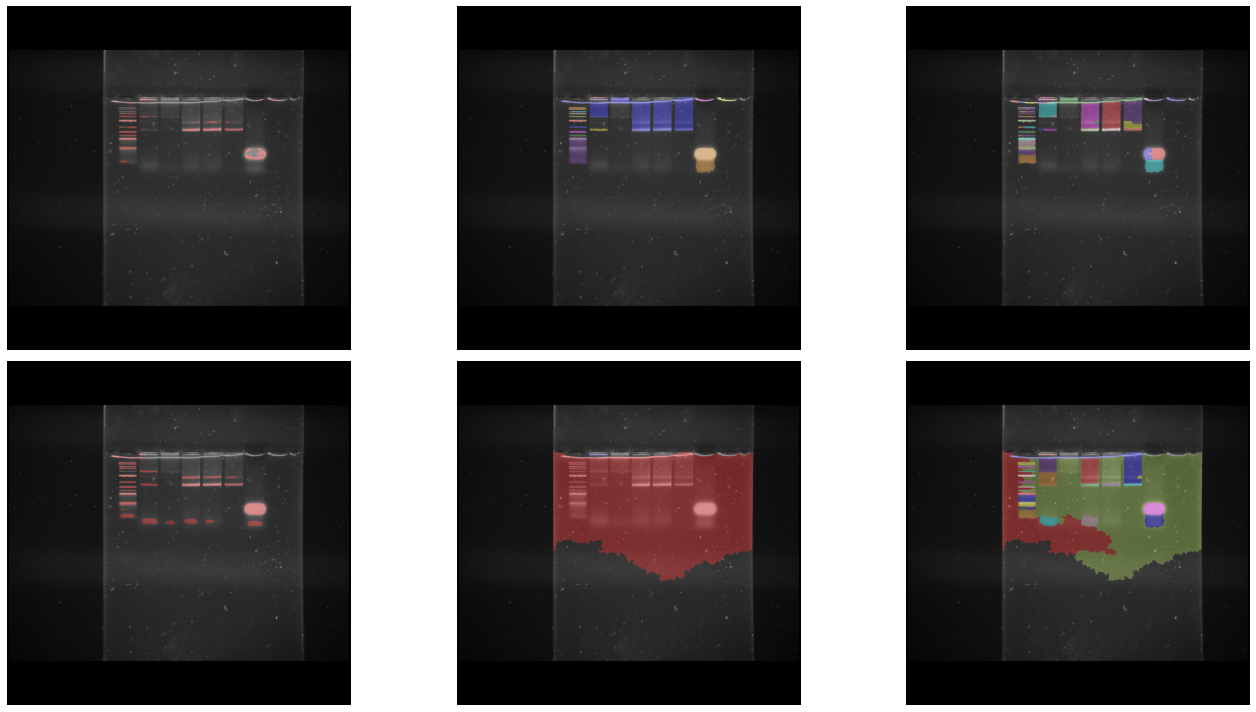

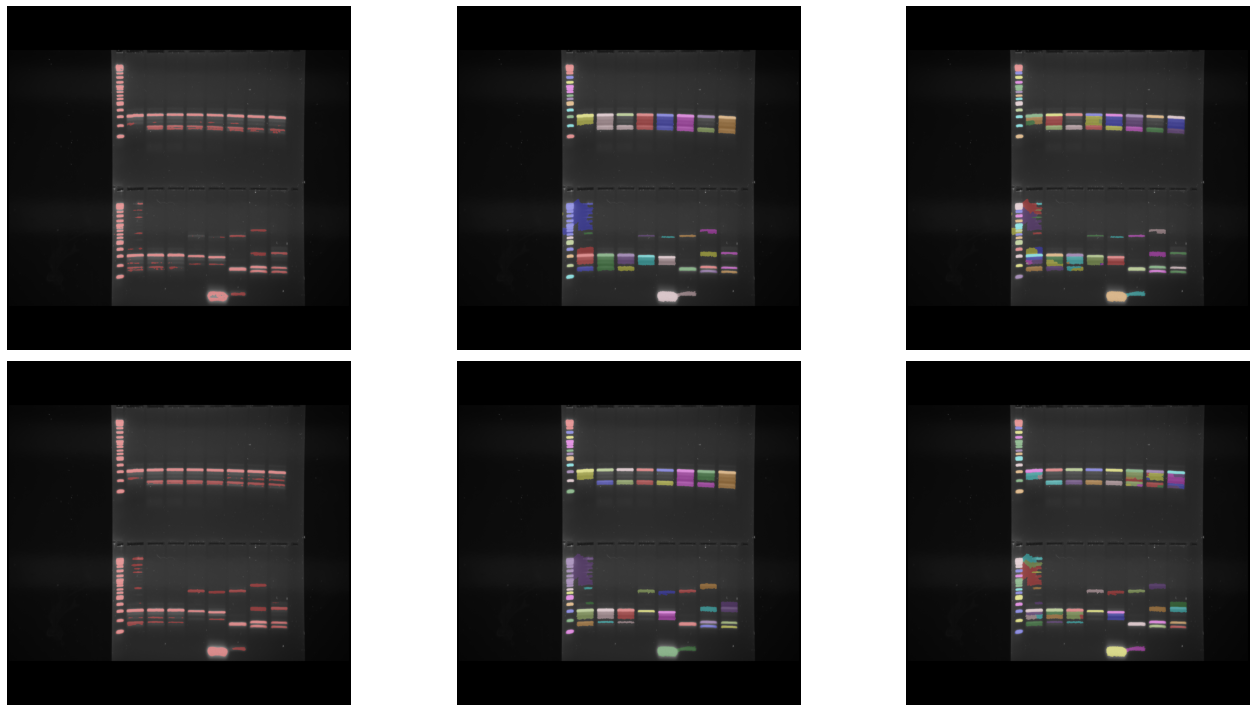

In [76]:
from PIL import Image

images_path = "/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/main_code/scratch_data/DL_scratch"
test_set = BasicDataset(images_path, n_channels, padding=True)
n_test = int(len(test_set))
test_loader = DataLoader(test_set, shuffle=False, batch_size=1, num_workers=0, pin_memory=True)
output_folder = '/Users/matt/Desktop/indiv_images'


def network_segment(pytorch_mask, np_input_image):

    background = skimage.filters.threshold_otsu(np_input_image)

    one_hot = F.one_hot(pytorch_mask.argmax(dim=1), 2).permute(0, 3, 1, 2).float()
    onn = one_hot.numpy().squeeze()

    output_segmentations = []

    for index, option in enumerate(['all_same', 'unique_bands']):
        if option == 'unique_bands':
            input_marker_array = ndi.binary_fill_holes(onn.argmax(axis=0))
            input_marker_array, _ = ndi.label(input_marker_array)
            input_marker_array[input_marker_array > 0] = input_marker_array[input_marker_array > 0] + 1
        else:
            input_marker_array = onn.argmax(axis=0)*2

        input_marker_array[(np_input_image < background) & (input_marker_array == 0)] = 1

        # Use Sobel filter on original image to find elevation map
        elevation_map = sobel(np_input_image)

        # Apply the watershed algorithm itself, using the elevation map and markers
        segmentation = skimage.segmentation.watershed(elevation_map, input_marker_array)

        if option != 'unique_bands':
            # Fill holes and relabel bands, giving each a unique label
            segmentation = ndi.binary_fill_holes(segmentation - 1)
            labeled_bands, _ = ndi.label(segmentation)
        else:
            labeled_bands = segmentation - 1

        # Overlay labels on original image
        image_label_overlay = label2rgb(labeled_bands, image=original_image)
        output_segmentations.append(image_label_overlay)
    return output_segmentations

def pil_save(image, filename):

    conv_array = (image * 255).astype(np.uint8)
    pil_im = Image.fromarray(conv_array)
    pil_im.save(os.path.join(output_folder, filename))

for im_index, image in enumerate(test_loader):

    fig, ax = plt.subplots(2,3, figsize=(20,10))
    for i in range(2):
        for j in range(3):
            ax[i,j].axis('off')

    original_image = image.squeeze().detach().squeeze().cpu().numpy()

    for model_index, net in enumerate(nets):
        with torch.no_grad():
            mask_pred = net(image)
        mask_pred.squeeze()

        watershed_segmentations = network_segment(mask_pred, original_image)

        one_hot = F.one_hot(mask_pred.argmax(dim=1), 2).permute(0, 3, 1, 2).float()
        onn = one_hot.numpy().squeeze()

        model_direct_labels = label2rgb(onn.argmax(axis=0), image=original_image)

        pil_save(model_direct_labels, 'image_%s_model_%s_direct_labels.png' % (im_index, model_index))
        ax[model_index, 0].imshow(model_direct_labels)

        for seg_index, seg_map in enumerate(watershed_segmentations):
            ax[model_index, seg_index+1].imshow(seg_map)
            if seg_index == 0:
                pil_save(seg_map, 'image_%s_model_%s_watershed_same_labels.png' % (im_index, model_index))
            elif seg_index == 1:
                pil_save(seg_map, 'image_%s_model_%s_watershed_unique_labels.png' % (im_index, model_index))

    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, '%s_no_aug_first_aug_second.png' % im_index), bbox_inches='tight', dpi=300)


### Other testing

/var/folders/4x/_gjrrkj918v37xmw7d8n_p2h0000gn/T/ipykernel_67947/2324908946.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_file)  # TODO: investigate the warning here...
/var/folders/4x/_gjrrkj918v37xmw7d8n_p2h0000gn/T/ipykernel_67947/2324908946.py:60: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


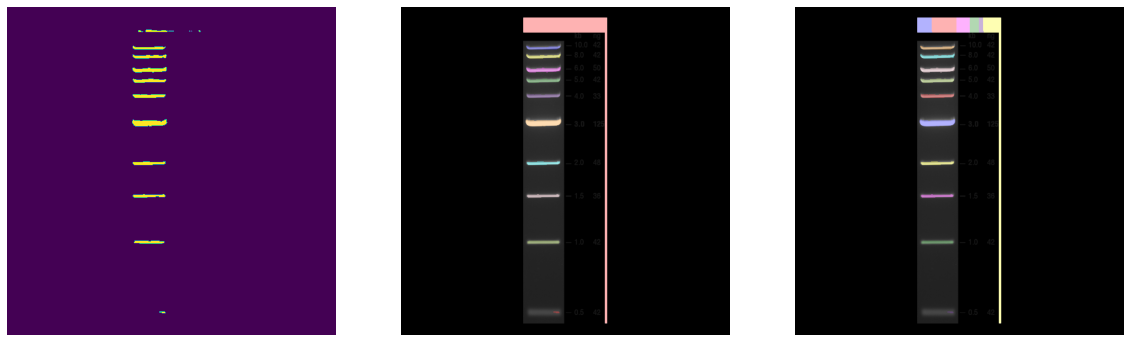

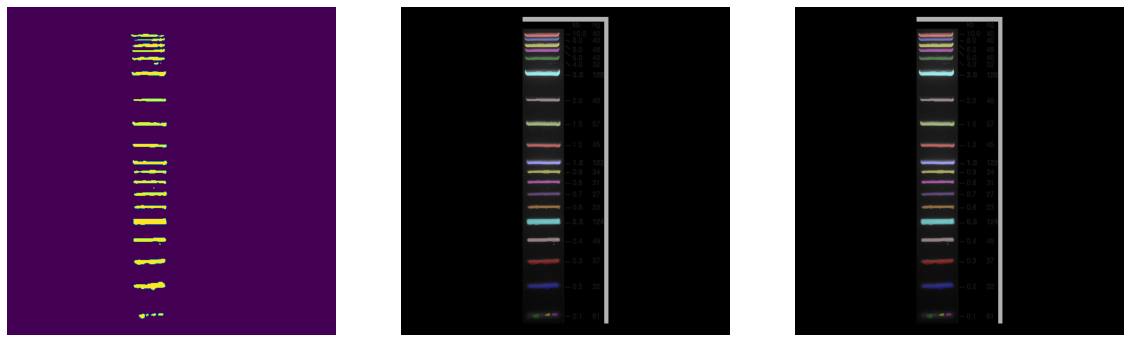

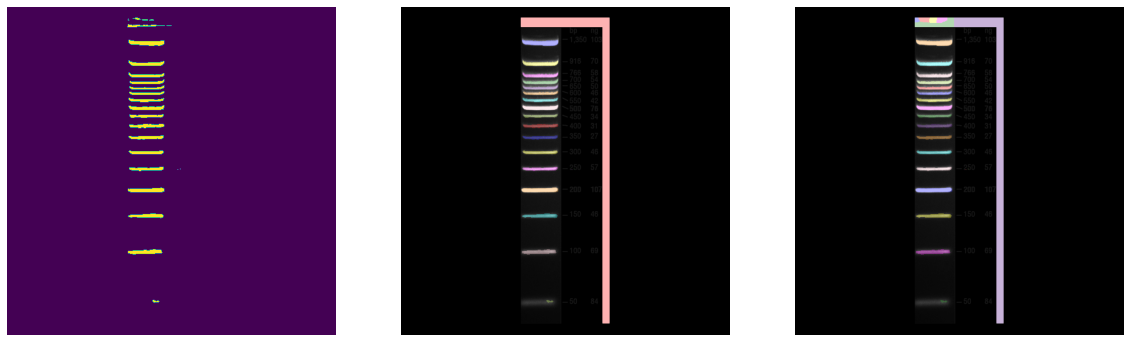

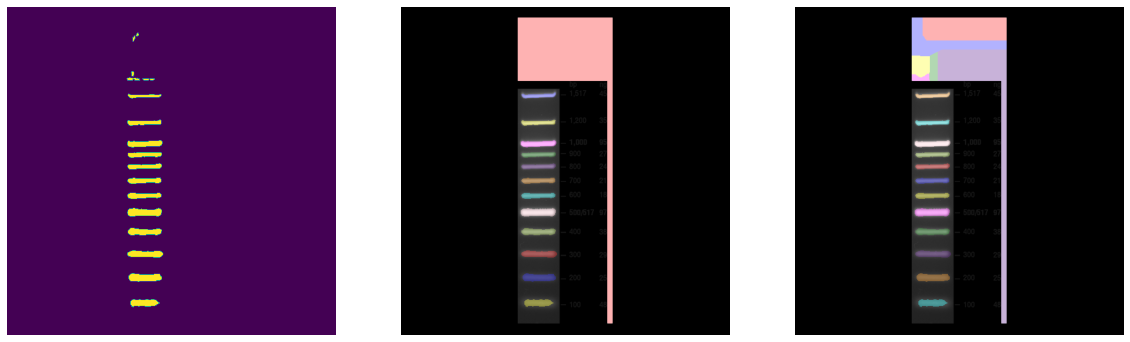

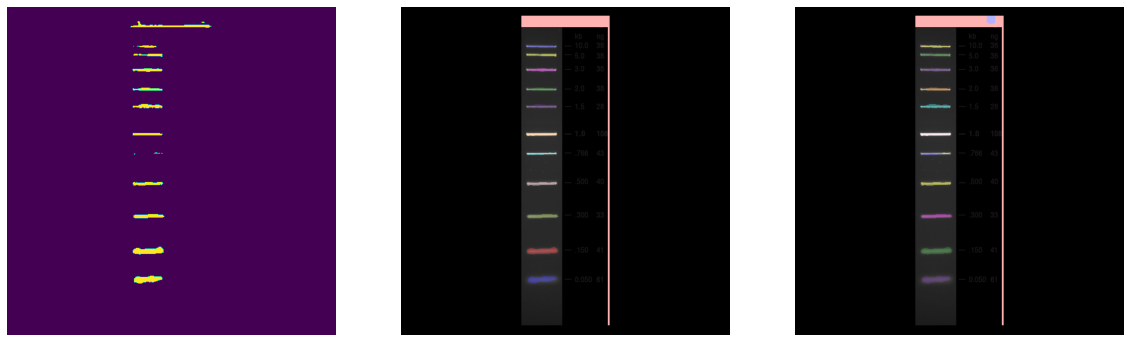

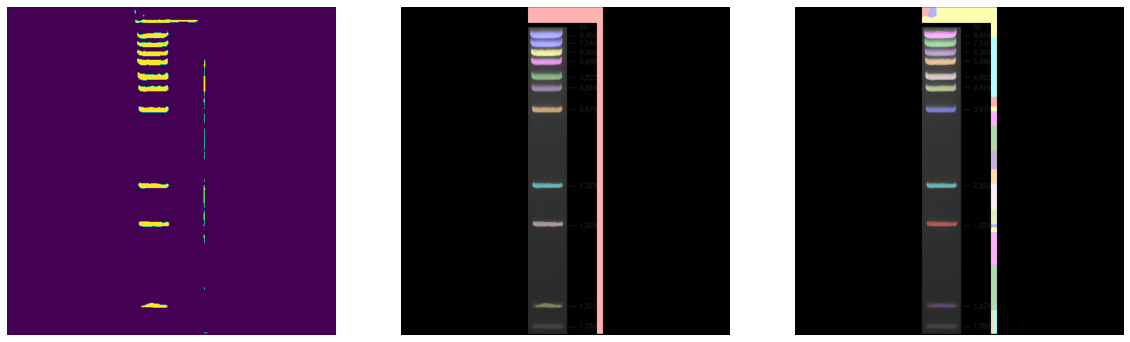

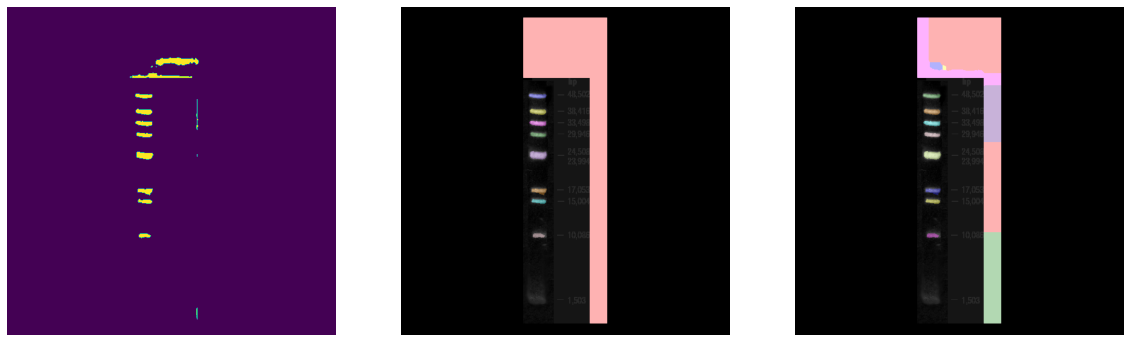

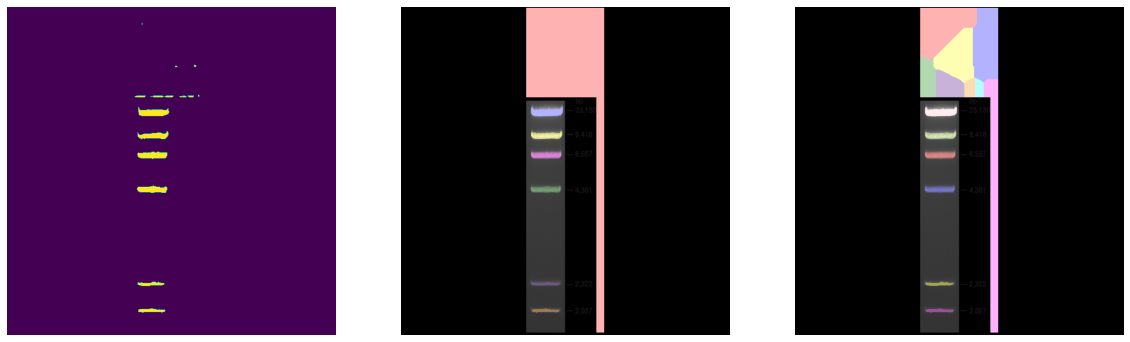

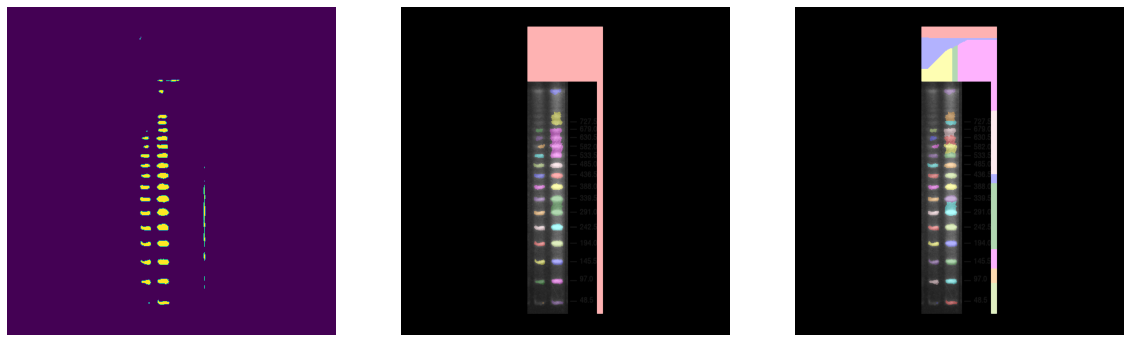

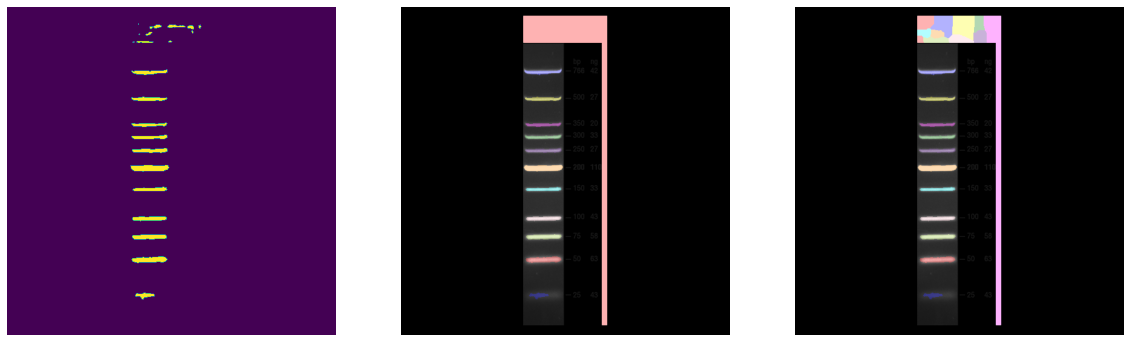

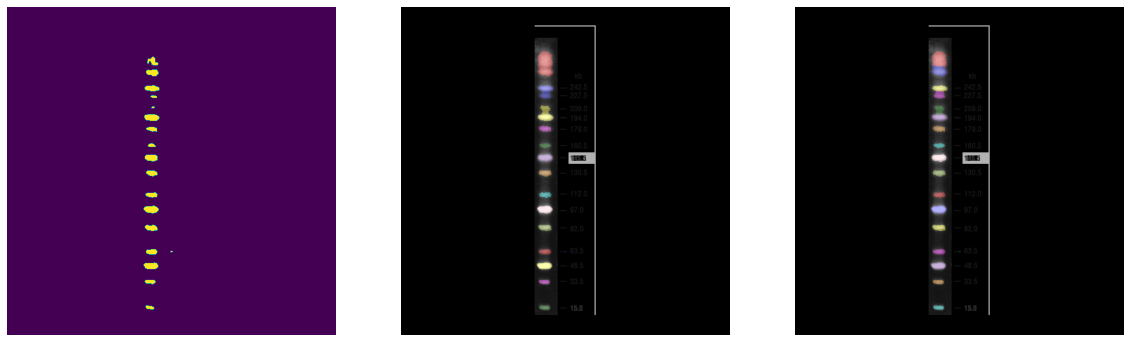

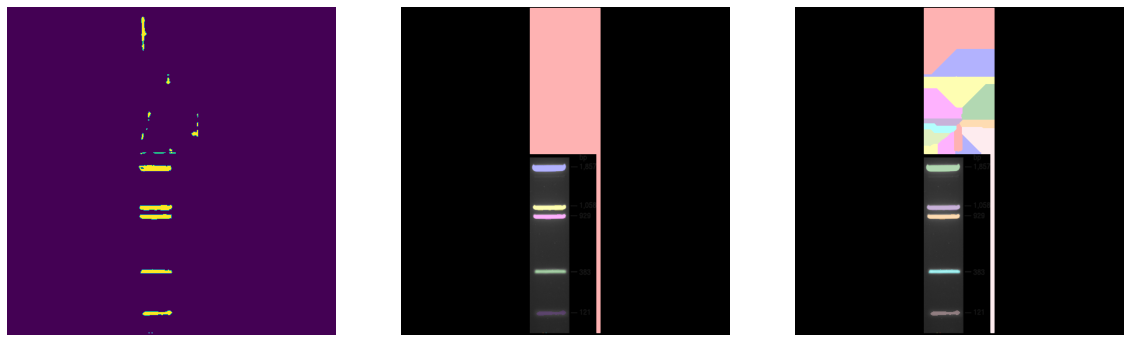

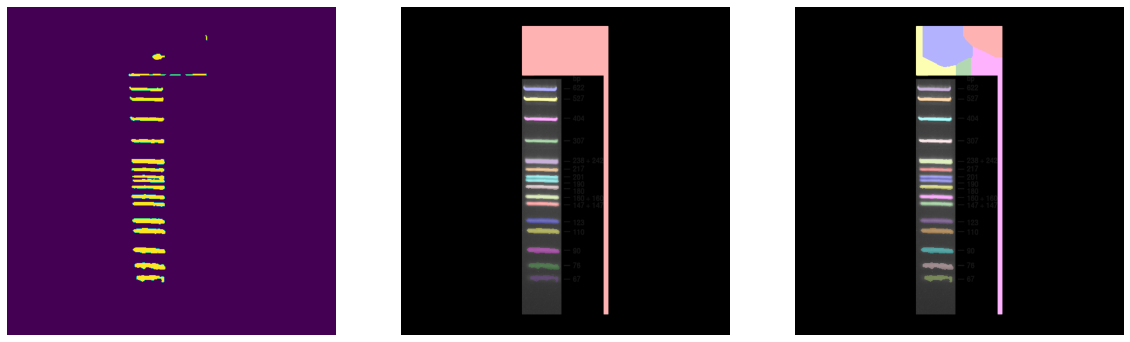

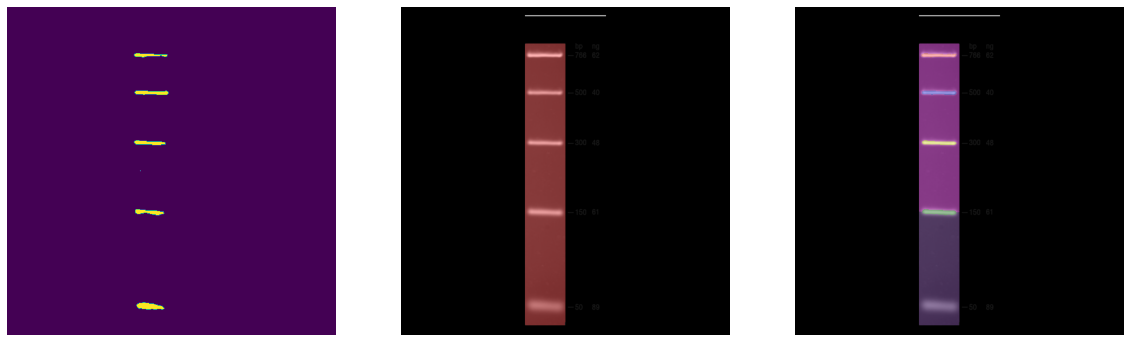

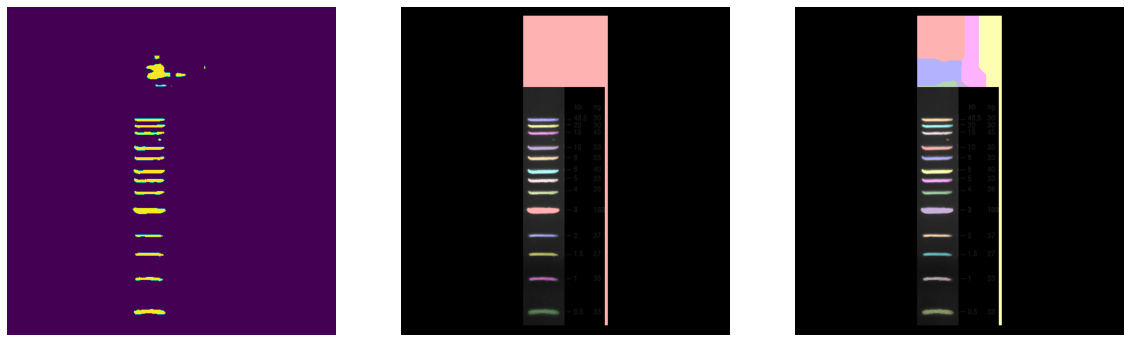

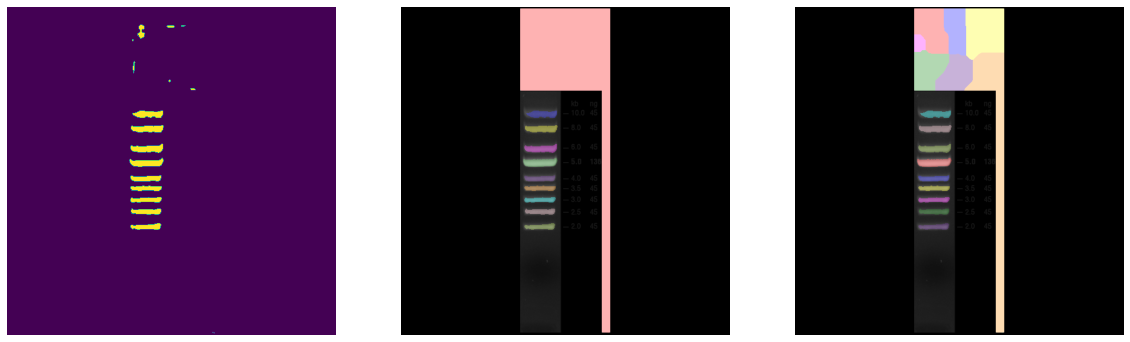

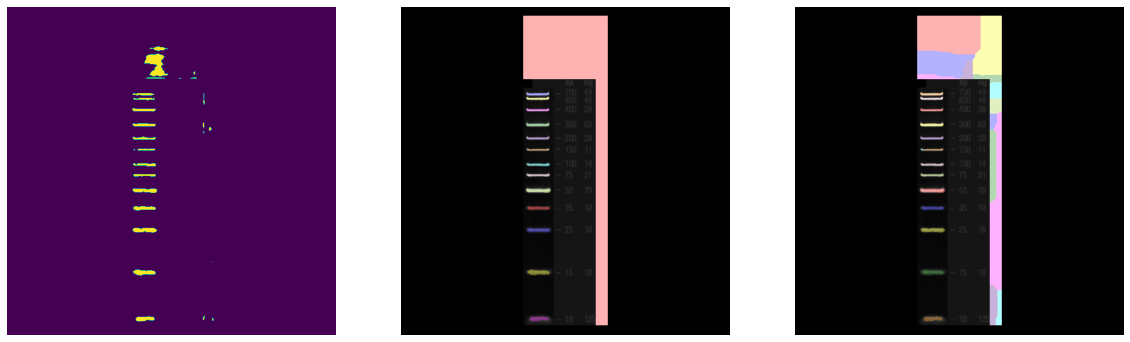

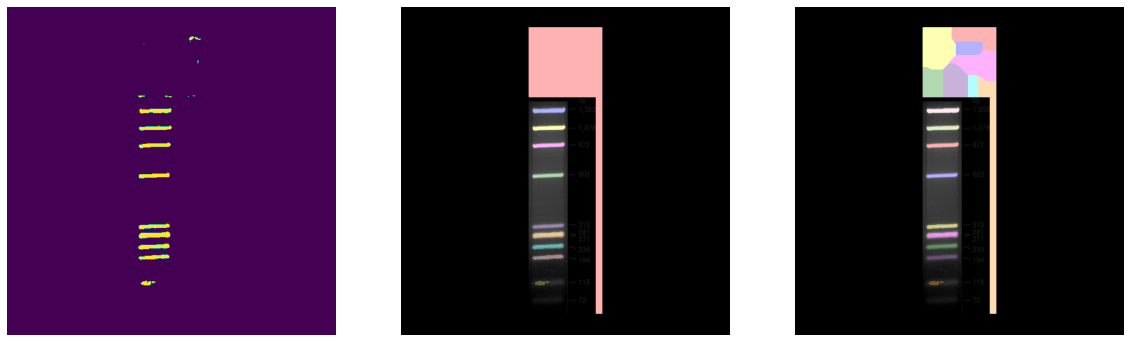

In [24]:
images_path = "/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/main_code/scratch_data/ladder_scratch"
test_set = BasicDataset(images_path, n_channels, padding=True)
n_test = int(len(test_set))
test_loader = DataLoader(test_set, shuffle=False, batch_size=1, num_workers=0, pin_memory=True)

background = 0.2

for image in test_loader:

    with torch.no_grad():
        mask_pred = net(image)
    image = image.squeeze()
    mask_pred.squeeze()

    original_image = image.detach().squeeze().cpu().numpy()

    background = skimage.filters.threshold_otsu(original_image)

    one_hot = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
    onn = one_hot.numpy().squeeze()

    fig, ax = plt.subplots(1,3, figsize=(20,10))
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[0].imshow(onn.argmax(axis=0))

    for index, option in enumerate(['all_same', 'unique_bands']):

        if option == 'unique_bands':
            input_marker_array = ndi.binary_fill_holes(onn.argmax(axis=0))
            input_marker_array, _ = ndi.label(input_marker_array)
            input_marker_array[input_marker_array > 0] = input_marker_array[input_marker_array > 0] + 1
        else:
            input_marker_array = onn.argmax(axis=0)*2

        input_marker_array[(original_image < background) & (input_marker_array == 0)] = 1

        # Use Sobel filter on original image to find elevation map
        elevation_map = sobel(original_image)

        # Apply the watershed algorithm itself, using the elevation map and markers
        segmentation = skimage.segmentation.watershed(elevation_map, input_marker_array)
        original_seg = np.copy(segmentation)

        if option != 'unique_bands':
            # Fill holes and relabel bands, giving each a unique label
            segmentation = ndi.binary_fill_holes(segmentation - 1)
            labeled_bands, _ = ndi.label(segmentation)
        else:
            labeled_bands = segmentation - 1

        # Overlay labels on original image
        image_label_overlay = label2rgb(labeled_bands, image=original_image)

        ax[index+1].imshow(image_label_overlay)


### Loss plot generation

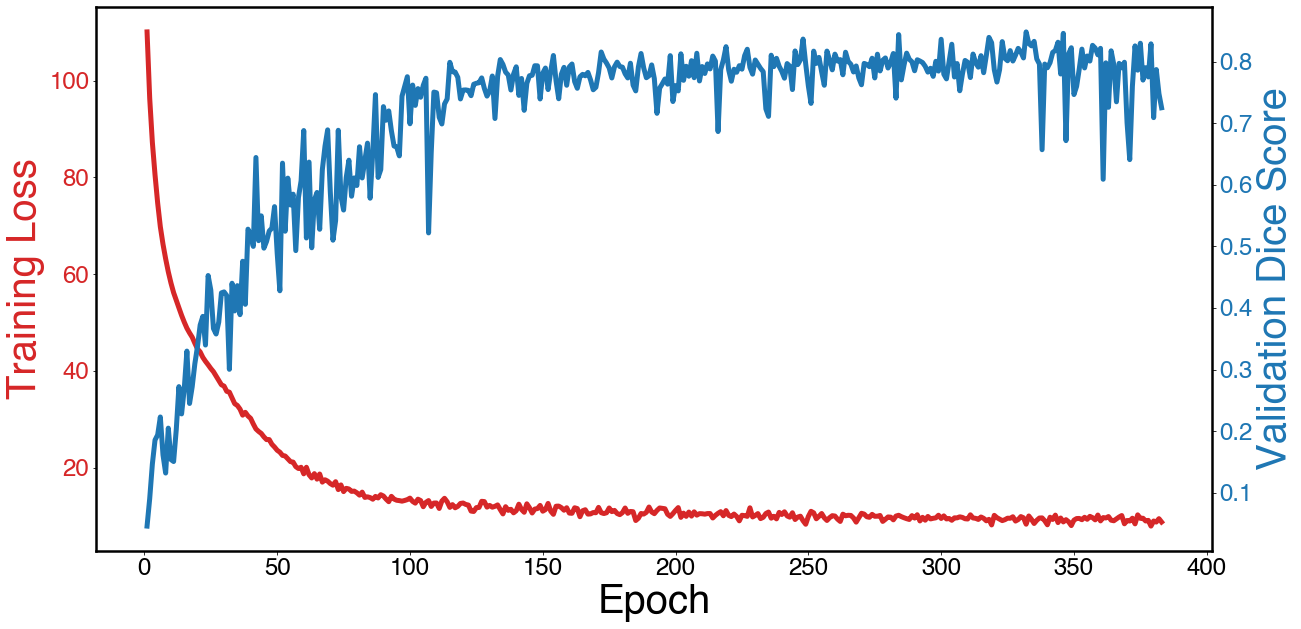

In [69]:
import pandas as pd

df = pd.read_csv('/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/segmentation_models/smp-UNet_with_Augmentations/loss.csv')

fig, ax = plt.subplots(figsize=(20,10))
ax2 = ax.twinx()

c1 = 'tab:red'
c2 = 'tab:blue'
label_size = 40
tick_size = 24
line_width = 5
plt.rcParams.update({'font.sans-serif':'Helvetica'})  # formatting for paper figures

[x.set_linewidth(2.5) for x in ax.spines.values()]

ax.plot(df['Epoch'], df['Training Loss'], label='Training Loss', color=c1, linewidth=line_width)
ax2.plot(df['Epoch'], df['Validation Dice Score'], label='Validation Dice Score', color=c2, linewidth=line_width)

ax.set_ylabel('Training Loss', color=c1, fontsize=label_size, weight="bold")
ax.set_xlabel('Epoch', fontsize=label_size, weight="bold")

ax2.set_ylabel('Validation Dice Score', color=c2, fontsize=label_size, weight="bold")

ax.tick_params(axis='y', labelcolor=c1, labelsize=tick_size)
ax.tick_params(axis='x', labelsize=tick_size)

ax2.tick_params(axis='y', labelcolor=c2, labelsize=tick_size)

plt.savefig('/Users/matt/Desktop/example_training_plot.png', bbox_inches='tight', dpi=300)
pass

### Example manual labelling

In [52]:
from PIL import Image
image_loc = '/Users/matt/Documents/PhD/thesis/figures/auto_gel/gel_data/example_labelled_sets'
out_folder = '/Users/matt/Desktop'
images = extract_image_names_from_folder(image_loc)

origs = [image for image in images if 'mask' not in image]
masks = [image for image in images if 'mask' in image]

for orig, mask in zip(origs, masks):
    image = np.array(imageio.v2.imread(orig))
    if image.shape[-1] == 4:
        image = image[:, :, :3]
    mask = np.array(imageio.v2.imread(mask))

    overlaid = label2rgb(mask, image=image)
    conv_array = (overlaid * 255).astype(np.uint8)
    pil_im = Image.fromarray(conv_array)
    pil_im.save(os.path.join(out_folder, '%s.png' % orig.split('/')[-1].split('.')[0]))



/var/folders/4x/_gjrrkj918v37xmw7d8n_p2h0000gn/T/ipykernel_31225/2324908946.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_file)  # TODO: investigate the warning here...
/var/folders/4x/_gjrrkj918v37xmw7d8n_p2h0000gn/T/ipykernel_31225/2324908946.py:60: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


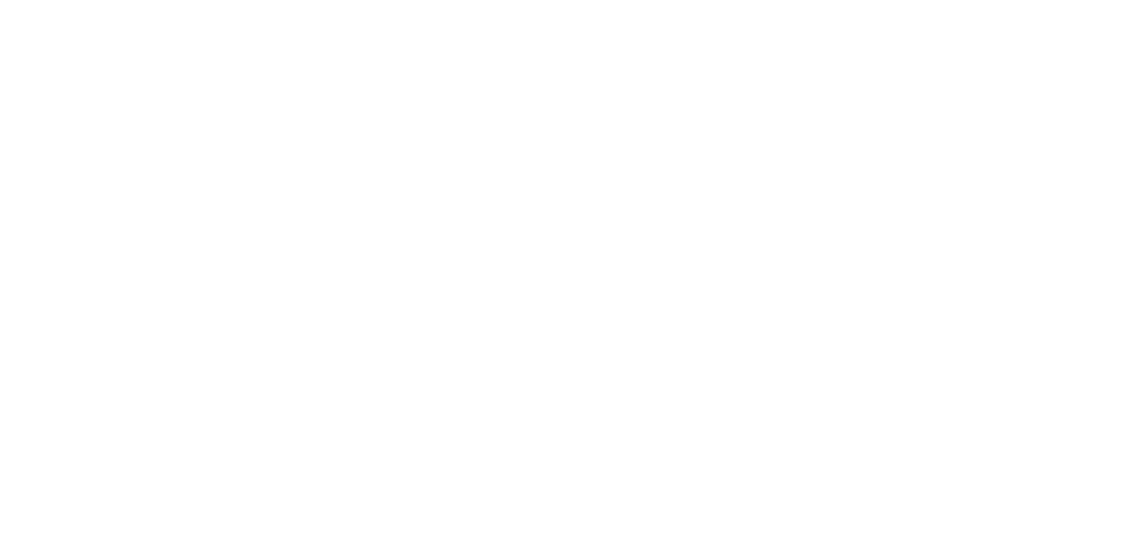

In [4]:
from PIL import Image

images_path = "/Users/matt/Documents/PhD/research_output/Automatic_Gel_Analyzer/main_code/scratch/scratch_data/DL_scratch"
test_set = BasicDataset(images_path, n_channels, padding=True)
n_test = int(len(test_set))
test_loader = DataLoader(test_set, shuffle=False, batch_size=1, num_workers=0, pin_memory=True)
output_folder = '/Users/matt/Desktop/indiv_images'


def network_segment(pytorch_mask, np_input_image):

    background = skimage.filters.threshold_otsu(np_input_image)

    one_hot = F.one_hot(pytorch_mask.argmax(dim=1), 2).permute(0, 3, 1, 2).float()
    onn = one_hot.numpy().squeeze()

    output_segmentations = []

    for index, option in enumerate(['all_same', 'unique_bands']):
        if option == 'unique_bands':
            input_marker_array = ndi.binary_fill_holes(onn.argmax(axis=0))
            input_marker_array, _ = ndi.label(input_marker_array)
            input_marker_array[input_marker_array > 0] = input_marker_array[input_marker_array > 0] + 1
        else:
            input_marker_array = onn.argmax(axis=0)*2

        input_marker_array[(np_input_image < background) & (input_marker_array == 0)] = 1

        # Use Sobel filter on original image to find elevation map
        elevation_map = sobel(np_input_image)

        # Apply the watershed algorithm itself, using the elevation map and markers
        segmentation = skimage.segmentation.watershed(elevation_map, input_marker_array)

        if option != 'unique_bands':
            # Fill holes and relabel bands, giving each a unique label
            segmentation = ndi.binary_fill_holes(segmentation - 1)
            labeled_bands, _ = ndi.label(segmentation)
        else:
            labeled_bands = segmentation - 1

        # Overlay labels on original image
        image_label_overlay = label2rgb(labeled_bands, image=original_image)
        output_segmentations.append(image_label_overlay)
    return output_segmentations

def pil_save(image, filename):

    conv_array = (image * 255).astype(np.uint8)
    pil_im = Image.fromarray(conv_array)
    pil_im.save(os.path.join(output_folder, filename))

for im_index, image in enumerate(test_loader):

    fig, ax = plt.subplots(2,3, figsize=(20,10))
    for i in range(2):
        for j in range(3):
            ax[i,j].axis('off')

    original_image = image.squeeze().detach().squeeze().cpu().numpy()

    for model_index, net in enumerate(nets):
        with torch.no_grad():
            mask_pred = net(image)
        mask_pred.squeeze()

        # watershed_segmentations = network_segment(mask_pred, original_image)

        one_hot = F.one_hot(mask_pred.argmax(dim=1), 2).permute(0, 3, 1, 2).float()
        onn = one_hot.numpy().squeeze()

        model_direct_labels = label2rgb(onn.argmax(axis=0), image=original_image)
        break

    break

    # plt.tight_layout()
    # plt.savefig(os.path.join(output_folder, '%s_no_aug_first_aug_second.png' % im_index), bbox_inches='tight', dpi=300)


In [6]:
mask_pred.shape

torch.Size([1, 2, 1376, 1376])

In [8]:
 F.one_hot(mask_pred.squeeze().argmax(dim=1), 2).permute(0, 3, 1, 2).float()


RuntimeError: Class values must be smaller than num_classes.